In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import subprocess
from glob import glob
from pkg import *
from pkg.functions import convert2int, convert2str, get_params
from typing import List, Dict, Any
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [2]:
datasets = [1, 4]

myPaths = path.PathManager(datasets=datasets)
myProcessor = process.Processor(paths=myPaths, datasets=datasets)
params = myProcessor.get_parameters()
print(params)
f.get_counts(paths=myPaths, datasets=datasets)

# myDatasetManager = data.DatasetManager(paths=myPaths, datasets=datasets)

# train_loader, test_loader = f.prepare(data_manager=myDatasetManager, batch_size=10)

Water backgrounds initialized: 2
{'01': {'clen': 0.15, 'photon_energy': 6000}, '04': {'clen': 0.25, 'photon_energy': 6000}}
Paths refreshed for dataset ['01', '04'].
Directory: peaks/01
	Total files: 58
	Normal images: 39
	Empty images: 19
Directory: labels/01
	Total files: 97
	Normal images: 78
	Empty images: 19
Directory: peaks_water_overlay/01
	Total files: 97
	Normal images: 78
	Empty images: 19
Directory: peaks/04
	Total files: 21
	Normal images: 14
	Empty images: 7
Directory: labels/04
	Total files: 35
	Normal images: 28
	Empty images: 7
Directory: peaks_water_overlay/04
	Total files: 35
	Normal images: 28
	Empty images: 7


In [3]:
f.check_attributes(paths=myPaths, datasets=f.convert2str(datasets), dir_type='peak')
print(myProcessor.get_parameters())

f.retrieve_attributes(file_path=myPaths.total_paths.water_background[0])

c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00001.h5 conforms to expected attributes.
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00001.h5:
Expected Peak: False, Actual Peak: False
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00002.h5 conforms to expected attributes.
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00002.h5:
Expected Peak: False, Actual Peak: False
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00003.h5 conforms to expected attributes.
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00003.h5:
Expected Peak: False, Actual Peak: False
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00004.h5 conforms to expected attributes.
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00004.h5:
Expected Peak: False, Actual Peak: False
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\emp

{'clen': 0.15, 'peak': False, 'photon_energy': 6000}

In [4]:
f.get_counts(paths=myPaths, datasets=datasets)
# %run process_directory.py ../../images  --percent_empty 0.5 

Paths refreshed for dataset ['01', '04'].
Directory: peaks/01
	Total files: 58
	Normal images: 39
	Empty images: 19
Directory: labels/01
	Total files: 97
	Normal images: 78
	Empty images: 19
Directory: peaks_water_overlay/01
	Total files: 97
	Normal images: 78
	Empty images: 19
Directory: peaks/04
	Total files: 21
	Normal images: 14
	Empty images: 7
Directory: labels/04
	Total files: 35
	Normal images: 28
	Empty images: 7
Directory: peaks_water_overlay/04
	Total files: 35
	Normal images: 28
	Empty images: 7


In [5]:
myDataManager = data.DatasetManager(paths=myPaths, datasets=datasets, transform=None)


train_loader, test_loader = f.prepare(data_manager=myDataManager, batch_size=10)

Actual percentage of empty images: 22.740524781341108% across peaks, water_overlays, and labels directories.

Final dataset sizes - Peaks: 79, Labels: 132, Overlays: 132

Data prepared.
Train size: 105
Test size: 27
Batch size: 10
Number of batches in train_loader: 11 



In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
optimizer = optim.Adam
scheduler = scheduler = ReduceLROnPlateau

cfg = {
    "loader": [train_loader, test_loader],
    'num_epochs': 10,
    'batch_size': train_loader.batch_size,
    'optimizer': optimizer,
    'device': device,
    'scheduler': scheduler
    }


peak_config = eval.Peak_Detection_Configuration(myPaths, datasets, device)
print(peak_config.get_loss_weights())
photon_config = eval.Photon_Energy_Configuration(myPaths, datasets, device)
print(photon_config.get_loss_weights())
clen_config = eval.Camera_Length_Configureation(myPaths, datasets, device)
print(clen_config.get_loss_weights())

cuda
Paths refreshed for dataset ['01', '04'].
tensor([0.2453])
Paths refreshed for dataset ['01', '04'].
tensor([1.0000, 2.7714, 1.0000])
Paths refreshed for dataset ['01', '04'].
tensor([1.0000, 2.7714, 1.0000])


Model testing and validating: Multi_Class_CNN1
Looking for the feature: peak
-- epoch 0
Train loss: 984.4828520037911
Train accuracy: 0.7523809671401978
Test loss: 869.657177734375
Test accuracy: 0.7777777910232544
-- epoch 1
Train loss: 510.5661770674315
Train accuracy: 0.7047619223594666
Test loss: 0.20538040101528168
Test accuracy: 0.7777777910232544
-- epoch 2
Train loss: 0.3094491945071654
Train accuracy: 0.3047619163990021
Test loss: 0.08887127190828323
Test accuracy: 0.2222222238779068
-- epoch 3
Train loss: 0.26557187736034393
Train accuracy: 0.190476194024086
Test loss: 0.08890268951654434
Test accuracy: 0.2222222238779068
-- epoch 4
Train loss: 0.27008027922023425
Train accuracy: 0.190476194024086
Test loss: 0.08889527469873429
Test accuracy: 0.2222222238779068
-- epoch 5
Train loss: 0.2746919352899898
Train accuracy: 0.190476194024086
Test loss: 0.08895703852176666
Test accuracy: 0.2222222238779068
-- epoch 6
Train loss: 0.27476412464271893
Train accuracy: 0.190476194024086


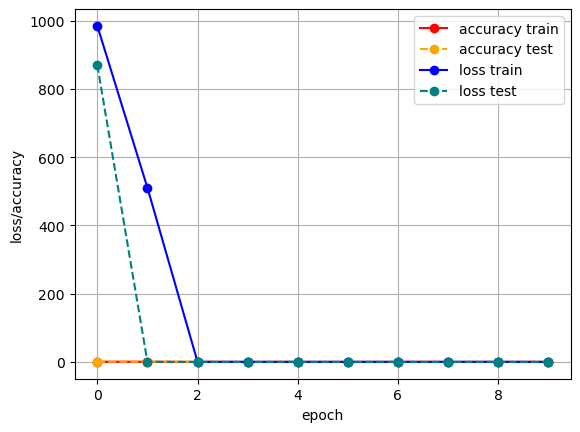

-- Labels      : [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]]
-- Predictions : [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


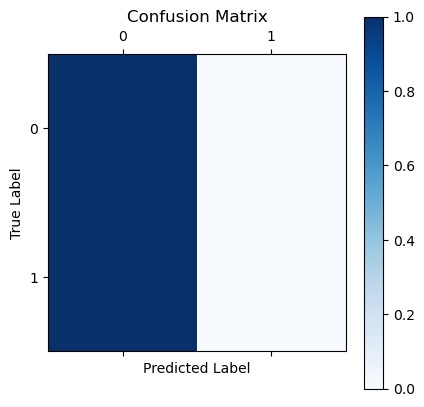

In [7]:
a = train_eval.TrainTestModels(cfg, peak_config)
a.epoch_loop()
a.plot_loss_accuracy()
a.plot_confusion_matrix()
a.get_confusion_matrix()
a.save_model('../models/peak_model.pt')

Model testing and validating: Multi_Class_CNN1
Looking for the feature: photon_energy
-- epoch 0
Train loss: 0.8228026493029161
Train accuracy: 0.6190476417541504
Test loss: 0.14412526786327362
Test accuracy: 1.0
-- epoch 1
Train loss: 0.3341463560407812
Train accuracy: 1.0
Test loss: 0.05589751750230789
Test accuracy: 1.0
-- epoch 2
Train loss: 0.14761739427393133
Train accuracy: 1.0
Test loss: 0.029287214577198028
Test accuracy: 1.0
-- epoch 3
Train loss: 0.08538014695725658
Train accuracy: 1.0
Test loss: 0.017623912170529367
Test accuracy: 1.0
-- epoch 4
Train loss: 0.04554009081965143
Train accuracy: 1.0
Test loss: 0.01096142646856606
Test accuracy: 1.0
-- epoch 5
Train loss: 0.03055505369874564
Train accuracy: 1.0
Test loss: 0.007533051585778594
Test accuracy: 1.0
-- epoch 6
Train loss: 0.02017040269195356
Train accuracy: 1.0
Test loss: 0.005560271197464317
Test accuracy: 1.0
-- epoch 7
Train loss: 0.015382770660587332
Train accuracy: 1.0
Test loss: 0.004253314365632832
Test accur

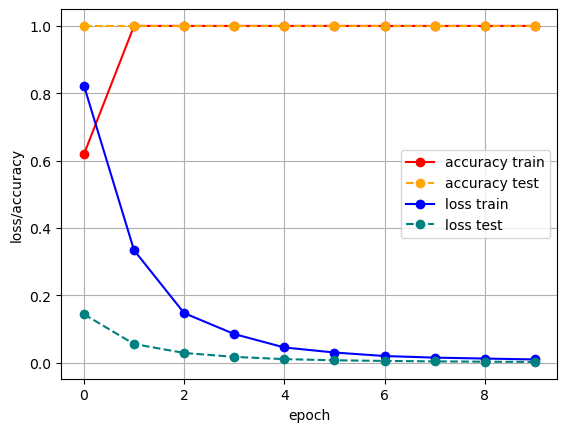

-- Labels      : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-- Predictions : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


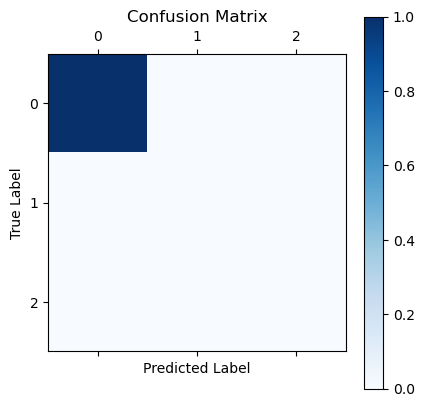

In [8]:
b = train_eval.TrainTestModels(cfg, photon_config)
b.epoch_loop()
b.plot_loss_accuracy()
b.plot_confusion_matrix()
b.get_confusion_matrix()
b.save_model('../models/photon_model.pt')

Model testing and validating: Multi_Class_CNN1
Looking for the feature: clen
-- epoch 0
Train loss: 1.0836269828406246
Train accuracy: 0.37142857909202576
Test loss: 0.1787734478712082
Test accuracy: 0.6666666865348816
-- epoch 1
Train loss: 0.30175842107696965
Train accuracy: 0.7523809671401978
Test loss: 0.12431440055370331
Test accuracy: 0.6666666865348816
-- epoch 2
Train loss: 0.21247039125724274
Train accuracy: 0.7523809671401978
Test loss: 0.06816912591457366
Test accuracy: 0.6666666865348816
-- epoch 3
Train loss: 0.1790168292143128
Train accuracy: 0.761904776096344
Test loss: 0.05493865087628365
Test accuracy: 1.0
-- epoch 4
Train loss: 0.12605733415958556
Train accuracy: 0.9142857789993286
Test loss: 0.07275938093662263
Test accuracy: 0.6666666865348816
-- epoch 5
Train loss: 0.10462760925292969
Train accuracy: 0.9142857789993286
Test loss: 0.02643977589905262
Test accuracy: 1.0
-- epoch 6
Train loss: 0.06565695484592156
Train accuracy: 1.0
Test loss: 0.02265952490270138
Test

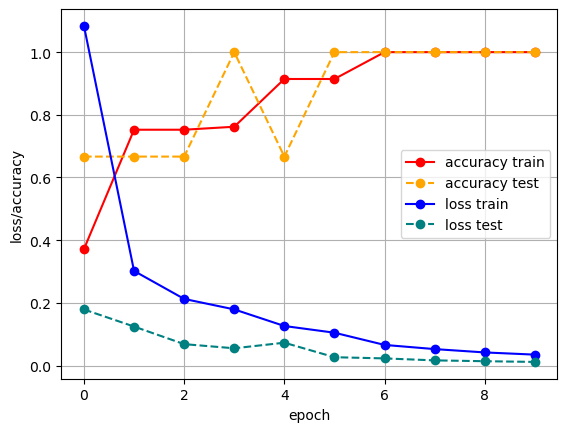

-- Labels      : [2 1 2 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 2 1 2 2 1 1 2 1 2]
-- Predictions : [2 1 2 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 2 1 2 2 1 1 2 1 2]


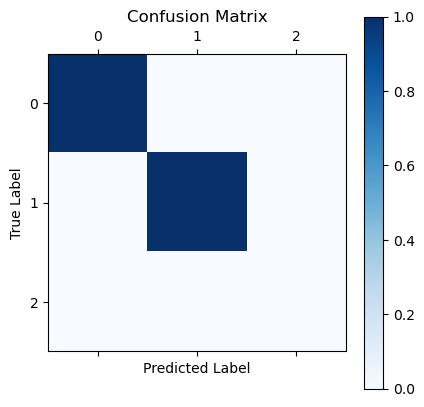

In [9]:
c = train_eval.TrainTestModels(cfg, clen_config)
c.epoch_loop()
c.plot_loss_accuracy()
c.plot_confusion_matrix()
c.get_confusion_matrix()
c.save_model('../models/clen_model.pt')

In [10]:
pipeline = pipe.ModelPipeline('../models/peak_model.pt', '../models/photon_model.pt', '../models/clen_model.pt', peak_config.get_model(), photon_config.get_model(), clen_config.get_model())

In [12]:
train_loader, test_loader = f.prepare(data_manager=myDataManager, batch_size=1)

for inputs, labels, attributes in train_loader:
    print(f'-- attributes: {attributes}')
    pipeline.run(inputs.to(device))
    break


Data prepared.
Train size: 105
Test size: 27
Batch size: 1
Number of batches in train_loader: 105 

-- attributes: {'clen': tensor([0.1500], dtype=torch.float64), 'peak': tensor([True]), 'photon_energy': tensor([6000], dtype=torch.int32)}


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [11]:
"""
How I want the pipeline to look.

cnn1_path = '../models/cnn1'
cnn2_path = '../models/cnn2'
cnn3_path = '../models/cnn3'

cnn1 = m.BasicCNN1()
cnn2 = m.BasicCNN2()
cnn3 = m.BasicCNN3()

pipeline = pipe.ModelPipeline(cnn1_path, cnn2_path, cnn3_path, cnn1, cnn2, cnn3)
pipeline.run(image)
pipeline.evaluate_results(image_path)
"""

"\nHow I want the pipeline to look.\n\ncnn1_path = '../models/cnn1'\ncnn2_path = '../models/cnn2'\ncnn3_path = '../models/cnn3'\n\ncnn1 = m.BasicCNN1()\ncnn2 = m.BasicCNN2()\ncnn3 = m.BasicCNN3()\n\npipeline = pipe.ModelPipeline(cnn1_path, cnn2_path, cnn3_path, cnn1, cnn2, cnn3)\npipeline.run(image)\npipeline.evaluate_results(image_path)\n"